# Autoencoder - on the MNIST dataset:

The following is an illustration/exercise in using an Auto-Encoder on image data. The general idea is, that if one can encode (i.e. represent with "few" parameters) images, and then from this encoding decode them again to obtain "almost" the same images, then the few parameters (in a latent space) contains the basic information about the images.

![](AutoEncoder.png "")

An AutoEncoder is trained by requiring that the output images match the input images *best possible*, which is (of course) represented by a loss function. Thus, **an AutoEncoder does not require labels**, and is as such unsupervised learning. The power lies in that one gets a good representation of the data through the latent space (the size of which you can choose) for essentially any NN-based method, here a CNN.

This can then be used (aggresively!) for many things such as:
* Compression (with loss!) of the images (to the size of the latent space)
* De-noising images
* Anomaly detection
* Unsupervised learning (e.g. clustering) on images, sound, graphs, etc.

In the example at hand, we consider the MNIST dataset (28x28 (=784) images of digits), and autoencode these images into a latent space of size 4. We then project this latent space onto just two dimensions using UMAP, and see if we (or a clustering algorithm) can detect clusters and possibly determine how many digits there are... *without ever having known anything about arabic numerals!!!*

***

Authors: Amalie Mygind and Troels Petersen (based on example from Medium)<br>
Date: 12th of May 2024 (latest version)

In [116]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import random 

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from umap import UMAP

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import itertools

In [117]:
# Convert data to torch.FloatTensor
transform = transforms.ToTensor()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the training and test datasets
train_dataset = datasets.MNIST('dataset', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST('dataset', train=False, download=True, transform=transform)

In [118]:
# Split training data into training and validation data:
full_len = len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(full_len-full_len*0.2), int(full_len*0.2)])
batch_size=256

### Question - do we need to split the data?

We somehow always split the data into these three datasets, but given that we are doing unsupervised learning here, try to think about the degree to which we need to divide the data in this way.

In [119]:
# Create PyTorch dataloaders for data:
train_loader = DataLoader(train_data, batch_size=batch_size)
valid_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

In [120]:
# Define the autoencoder model (explained in comments below):

class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section:
        # So we decide to take our 1 input image and first apply 8 kernels/filters of size 3x3
        # with a stride (i.e. step size) of 2 and padding the edge with one layer.
        # This output goes through a ReLU and then through 16 new kernels/filters
        # of the same size, stride and padding, which is then BatchNorm'ed, ReLU'ed, and finally
        # convoluted a third time, again doubling the number of kernels/filters (quite standard!).
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        # The images/matrices are then flatten'ed (put into one long array), put through a linear layer,
        # then a ReLU, and then finally another linear layer, which boils it down to the latent space
        # dimension.
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    

class Var_Encoder(nn.Module):
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section:
        # So we decide to take our 1 input image and first apply 8 kernels/filters of size 3x3
        # with a stride (i.e. step size) of 2 and padding the edge with one layer.
        # This output goes through a ReLU and then through 16 new kernels/filters
        # of the same size, stride and padding, which is then BatchNorm'ed, ReLU'ed, and finally
        # convoluted a third time, again doubling the number of kernels/filters (quite standard!).
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        # The images/matrices are then flatten'ed (put into one long array), put through a linear layer,
        # then a ReLU, and then finally another linear layer, which boils it down to the latent space
        # dimension.
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        ### variationnal part
        self.variational_mean = nn.Linear(encoded_space_dim, encoded_space_dim)
        self.variational_var = nn.Linear(encoded_space_dim, encoded_space_dim)

    def reparameterization(self, mean, var): #Stolen from MNIST example, device must be understood
        epsilon = torch.randn_like(var).to(device) 
        z = mean + var*epsilon
        return z

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        mean = self.variational_mean(x)
        log_var = self.variational_var(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        return z, mean, log_var

    
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### The decoder does the exact opposite, reconstructing the images from the latent space values.
        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [125]:
# Define loss function and training parameters:
def loss_fn(recon_x, x, mean, log_var):
    #MSE = nn.MSELoss()(recon_x, x) 
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    #print(MSE, KLD)
    lambda_= 1
    return BCE + lambda_ * KLD
# Define the loss function




# Define an optimizer (both for the encoder and the decoder!)
lr = 0.001

# Set the random seed for reproducible results
torch.manual_seed(42)

# Initialize the two networks
d = 4
encoder = Var_Encoder(encoded_space_dim=d, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d, fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

In [126]:
# Define training and validation functions:

### Training function
def train_epoch(encoder, decoder, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Encode data
        encoded_data, mean, var = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch, mean, var)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
#         print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)


### Testing function
def test_epoch(encoder, decoder, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Encode data
            encoded_data, mean, var = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label, mean, var)
    return val_loss.data


def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
        
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img)[0])
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()   

### Question - what is the dimension of the latent space?

Ask yourself, how many dimensions we boild the images down to, i.e. how many numbers represent what the images look like?

NOTE: You may want to launch the training cell below (which takes a few minutes) and then think about the answer.


 EPOCH 1/10 	 train loss 90631.8046875 	 val loss 2444381.75


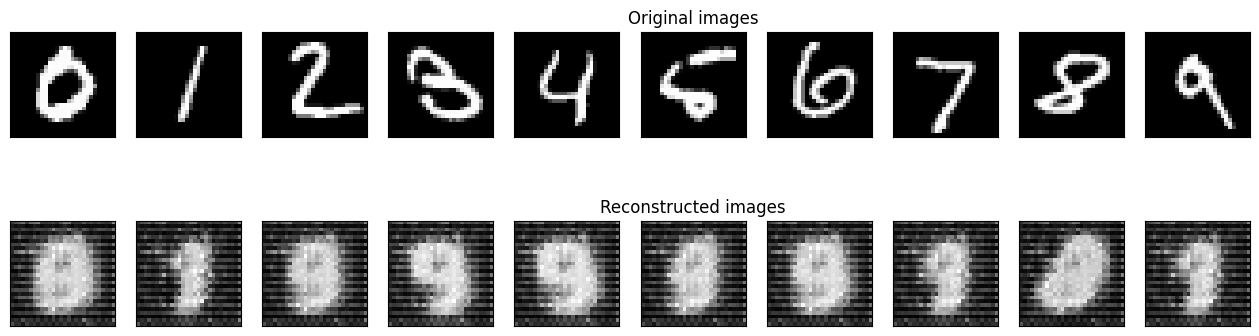


 EPOCH 2/10 	 train loss 53783.1640625 	 val loss 1798378.75


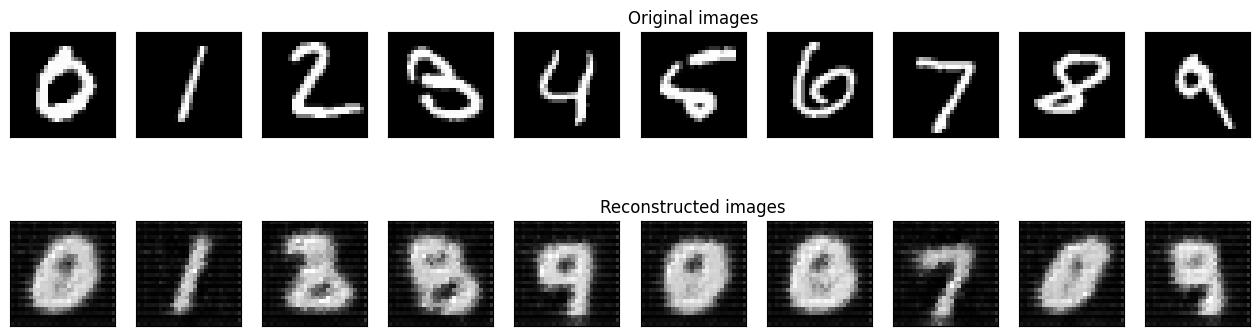


 EPOCH 3/10 	 train loss 44771.203125 	 val loss 1633068.125


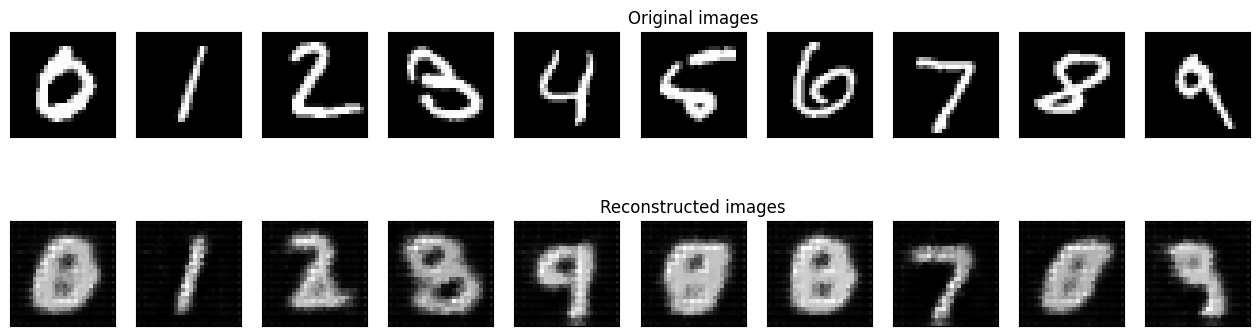


 EPOCH 4/10 	 train loss 42030.953125 	 val loss 1559874.375


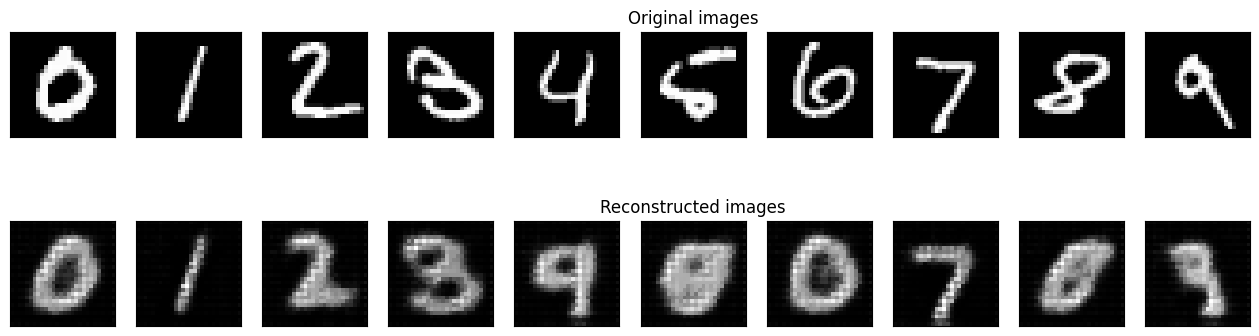


 EPOCH 5/10 	 train loss 40030.2890625 	 val loss 1466994.5


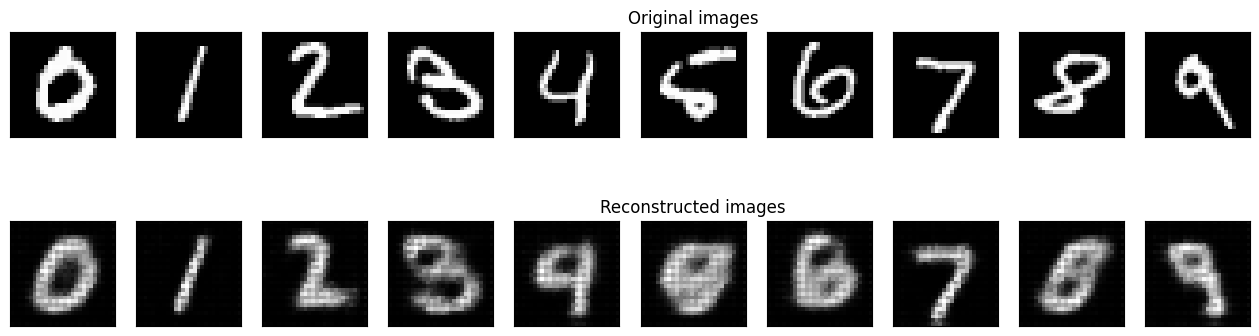


 EPOCH 6/10 	 train loss 38161.5546875 	 val loss 1408231.0


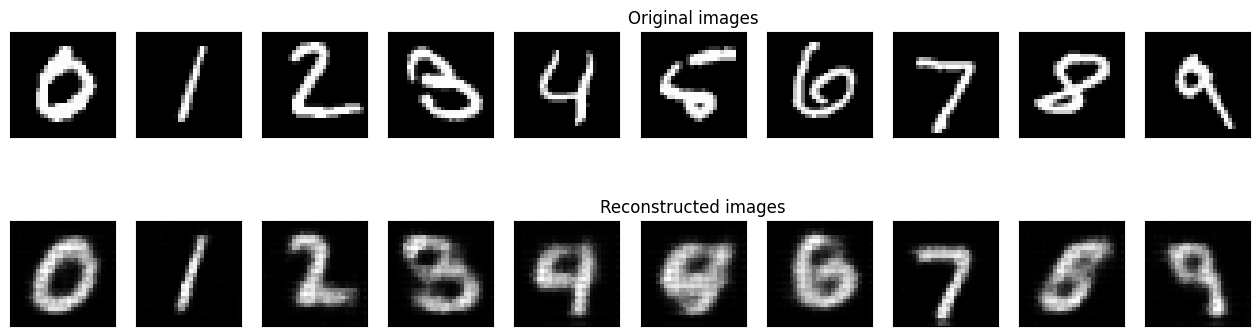


 EPOCH 7/10 	 train loss 37155.04296875 	 val loss 1380110.375


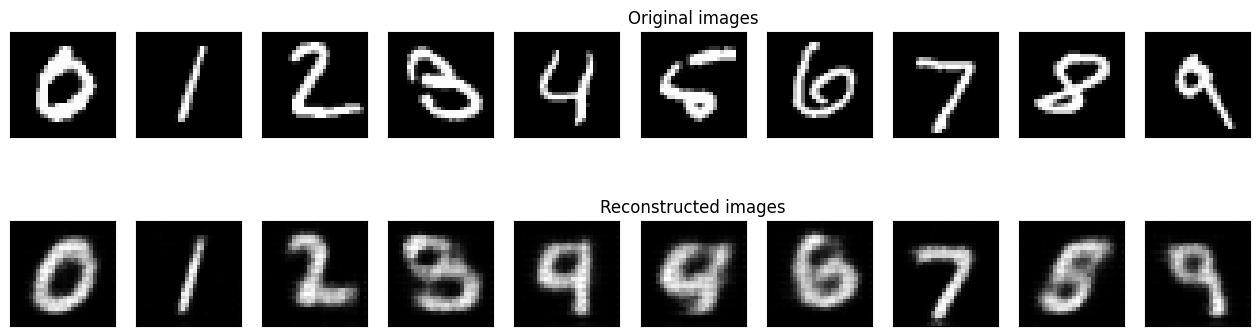


 EPOCH 8/10 	 train loss 36589.546875 	 val loss 1358713.0


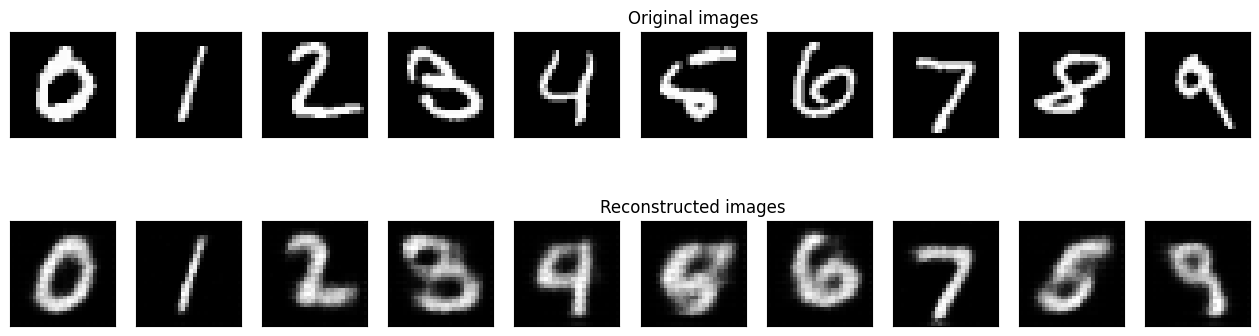


 EPOCH 9/10 	 train loss 36163.3828125 	 val loss 1342293.875


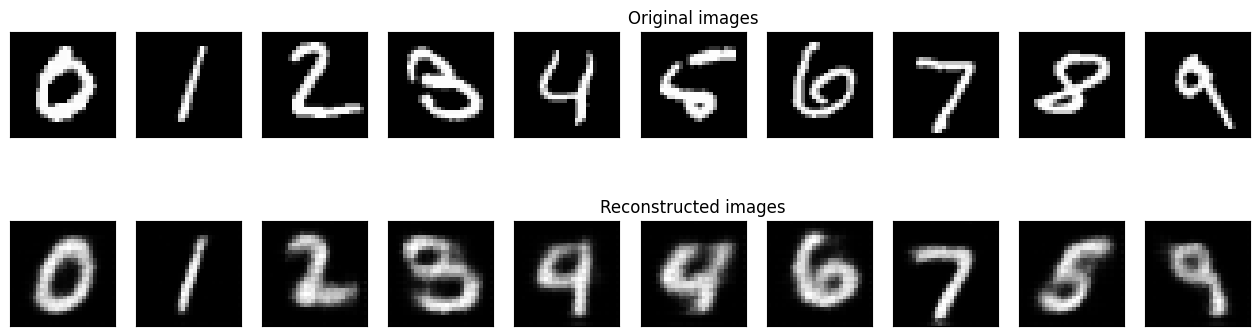

In [127]:
# Train the model
num_epochs = 10
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(encoder,decoder, train_loader, loss_fn, optim)
    val_loss = test_epoch(encoder,decoder,test_loader,loss_fn)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    plot_ae_outputs(encoder,decoder,n=10)

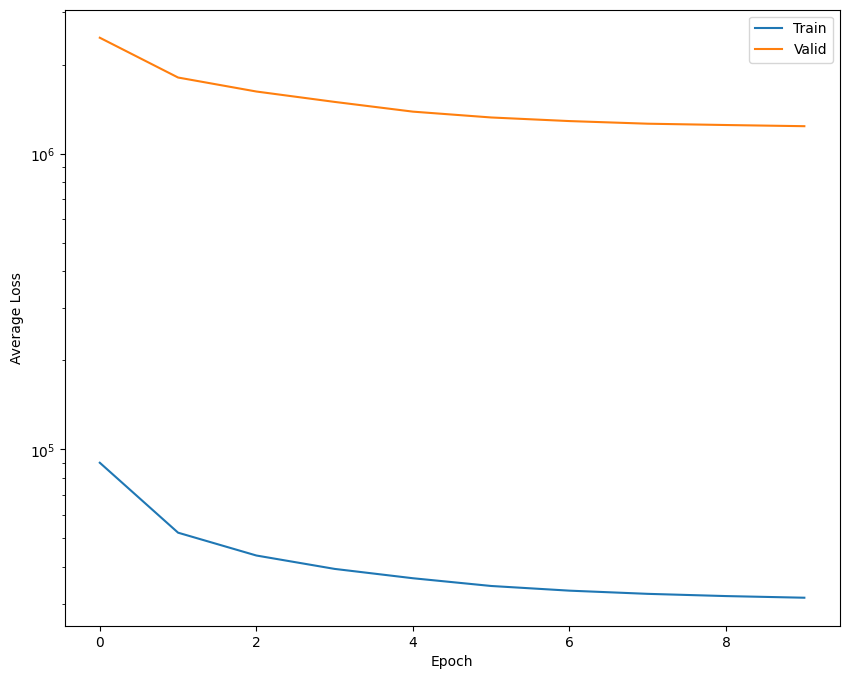

In [114]:
# Plot losses over epochs:
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

### Extract latent space representation

In [ ]:
# Perform forward pass on test set and subtract latent layer (and labels):
latent_test = []
labels_test = []
for step, (images, labels) in enumerate(test_loader): 
    with torch.no_grad():
        latent = encoder(images)
    latent_test.extend(latent.numpy())
    labels_test.extend(labels.numpy())  
    
# labels_str = list(map(str, labels_test))
    
print(f'latent shape: {np.shape(latent_test)}, labels shape: {np.shape(labels_test)}')

latent shape: (10000, 4), labels shape: (10000,)


## Reduce latent space with UMAP

In [ ]:
# Fit a (possibly parametric!) UMAP embedding to the latent space representation:
# embedder = ParametricUMAP(n_epochs=50, n_neighbors=20, min_dist=0.1)
embedder = UMAP(n_neighbors=50, min_dist=0.2)
embedding = embedder.fit_transform(latent_test)

### Question - can you "train" UMAP on a training set, and then apply the same model to a test set?

Seeing how t-SNE and UMAP iteratively got to their resulting projections, do you think that at the end of the process there is a model, that can be applied to other data? And if not, can you think about, how one could construct a good approximation?

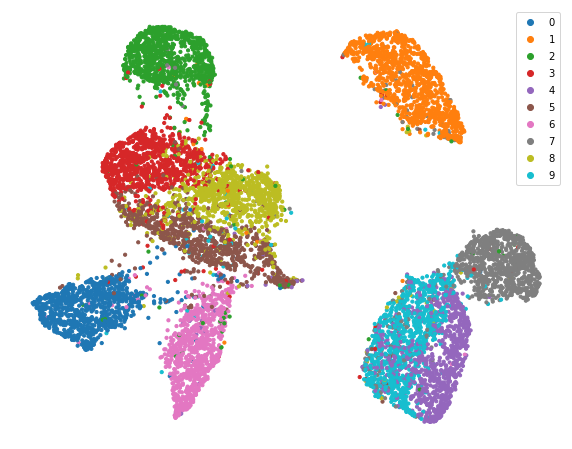

In [ ]:
# Plot embedding without example images:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = plt.cm.tab10
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=labels_test, s=10, cmap=cmap)
ax.legend(*scatter.legend_elements())
ax.axis("off");

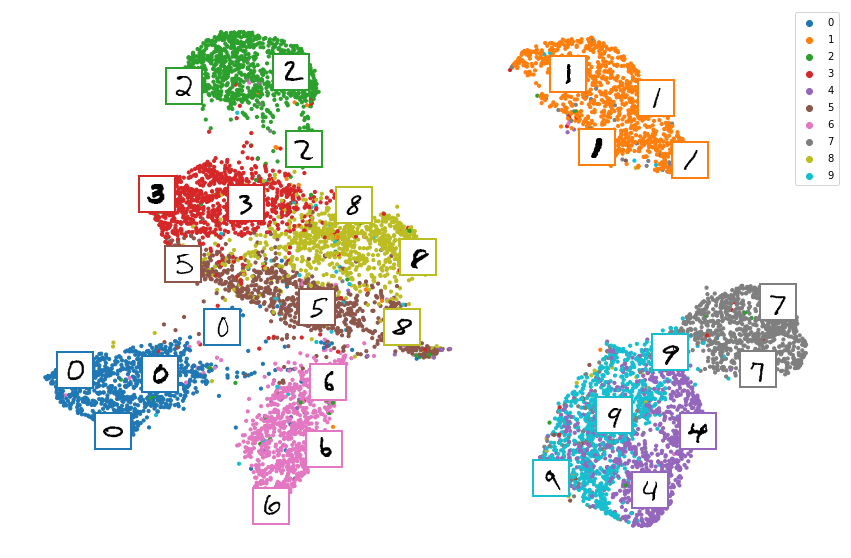

In [ ]:
# Plot embedding with example images:
fig, ax = plt.subplots(figsize=(15, 10))
cmap = plt.cm.tab10
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=labels_test, s=10, cmap=cmap)
ax.legend(*scatter.legend_elements())
image_positions = np.array([[1., 1.]])
for index, position in enumerate(embedding):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 4:            # If far enough from other images...
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(test_dataset[index][0][0], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(labels_test[index]), "lw": 2})
        fig.gca().add_artist(imagebox)
ax.axis("off");

In [ ]:
# k-means clustering of embedding:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(embedding)
clusters = pd.DataFrame(kmeans.labels_, columns=['Cluster'])

classes = np.array(labels_test)
class_names = [0,1,2,3,4,5,6,7,8,9]

clust0 = clusters.loc[clusters['Cluster'] == 0].index.to_numpy()
clust1 = clusters.loc[clusters['Cluster'] == 1].index.to_numpy()
clust2 = clusters.loc[clusters['Cluster'] == 2].index.to_numpy()
clust3 = clusters.loc[clusters['Cluster'] == 3].index.to_numpy()
clust4 = clusters.loc[clusters['Cluster'] == 4].index.to_numpy()
clust5 = clusters.loc[clusters['Cluster'] == 5].index.to_numpy()
clust6 = clusters.loc[clusters['Cluster'] == 6].index.to_numpy()
clust7 = clusters.loc[clusters['Cluster'] == 7].index.to_numpy()
clust8 = clusters.loc[clusters['Cluster'] == 8].index.to_numpy()
clust9 = clusters.loc[clusters['Cluster'] == 9].index.to_numpy()
cluster_list = [clust0, clust1, clust2, clust3, clust4, clust5, clust6, clust7, clust8, clust9]

real_labels = np.concatenate([classes[clust0], classes[clust1], classes[clust2], classes[clust3], classes[clust4], classes[clust5],
                             classes[clust6], classes[clust7], classes[clust8], classes[clust9]])
pred_labels = []

for cluster in cluster_list:
    unique, pos = np.unique(classes[cluster], return_inverse=True)
    maxpos = np.bincount(pos).argmax()
    cluster_label = unique[maxpos]
    for i in range(len(cluster)):
        pred_labels.append(cluster_label)

pred_labels = np.array(pred_labels)

In [ ]:
# Function to plot confusion matrix:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          savefig = ''):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=16)
        plt.yticks(tick_marks, target_names, fontsize=16)
        

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=13,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=16,
                     color="white" if cm[i, j] > thresh else "black")


    #plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel(f'Predicted label\n\n accuracy={accuracy:0.3f}; misclass={misclass:0.3f}', fontsize=16)
    cbar.ax.set_ylabel('Number of items',  labelpad=20, rotation=270, fontsize=16)   
    
    
    if savefig: plt.savefig(savefig, bbox_inches='tight')
    
    plt.show()

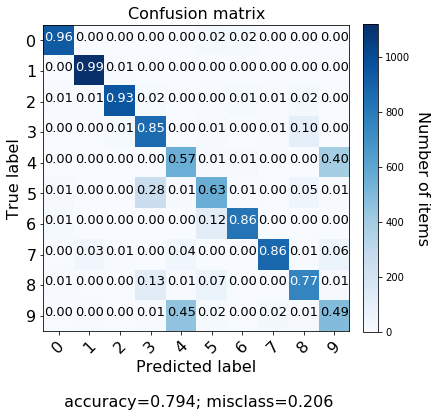

In [ ]:
# Plot confusion matrix:
cm = confusion_matrix(real_labels, pred_labels, labels=class_names)
plot_confusion_matrix(cm, target_names=class_names)

### Question - are you satisfied with the confusion matrix?

Is the performance "good enough"? If not, what do you think is the problem, and how could it be solved in a simple manner? And if this is not enough, discuss what else could be done. 

### Final questions - could you learn the number of digits?

Imagine that you didn't know the digits (or something else like zebra calls!), and wanted to estimate this. Can you think of how to do that, and would you be sure to get the right result or a reasonable estimate of it?